# Livrable 3 : Captioning

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/20|
|Nicolas Hurtevent|Toulouse|2021/01/20|
|Pierre Mazurier|Toulouse|2021/01/20|
|Pacome Chu-Lejeune|Toulouse|2021/01/20|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning.


L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captioning (génération de description).

Dans ce document, nous réalisons le module de captioning.

Ce modèle sera utilisé par la suite sur la solution finale.

A noter que l'ensemble du code proposé est basé du Workshop CESI ainsi que le [tutoriel](https://www.tensorflow.org/tutorials/text/image_captioning?hl=fr) TensorFlow sur le sous-titrage d'images.

# Sommaire

- Mise en place de TensorFlow
- 1. Architecture du module de captioning
- 2. Pré-traitements
- 3. Explication des GRU
- 4. Mécanisme d'attention de Bahdanau
- 5. Fonctions et dataset
- 6. Mise en place du CNN
- 7. Prétraitement du texte 
- 8. Préparation du jeu d'entrainement et du jeu de validation
- 9. Modèles de notre encodeur et de notre décodeur
- 10. Entrainement du modèle
- 11. Prédiction
- 12. Éxecution du modèle
- Conclusion

## Mise en place de tensorflow

Si ce n'est pas déjà fait dans le livrable précèdent et que vous souhaitez tester le code, il est nécessaire d'utiliser TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

## 1. Architecture du module de captionning

Le module de captionning est la derinière partie de la solution globale. Ce module permet de générer une description pour une image donnée.

Ce module est composé de deux réseaux de neurones : un réseau de neurones convolutif pour traiter l'image un réseau de neuronnes récurrent, qui lui est chargé de générer une déscription à partir de l'image traitée.

![](images/model2.png)

Le principe général est le suivant :
1. Nous mettons en entrée notre image dans un encoder (CNN) qui est un modèle pré-entrainé, à savoir Inception V3. Le modèle InceptionV3 sera détaillé plus tard dans ce document.
2. Au lieu d'afficher la catégorie de l'image et donc d'utiliser la dernière couches du modèle, nous prenons l'avant-dernière couche de ce modèle et l'envoyons vers un interpreter. C'est une Dense MAP (une couche dense de neurones) qui va préparer les données brutes que nous avons en quelque chose de plus lisible pour notre décodeur.
3. Ces données encodées vont ensuite vers un décodeur qui est un RNN que entrainons sur le dataset MS-COCO contenant une multitude d'image avec des descriptions associéees. Il prend comme entrée les données de sortie de la dernière couche de l'encodeur (CNN) qui viennent d'être traitées par la Dense Map.
4. De son côté, notre RNN va générer un vocabulaire à partir de tous les descriptions qu'il a reçu. Le nombre de mots utilisé est limité. Il va donc remplacer les mots ne figurant pas dans son vocabulaire par un jeton "[UNK]"
5. Il va ensuite tokeniser ce vocabulaire, c'est à dire transformer nos mots en un format numérique pour pouvoir les exploiter.
6. La prochaine étape est de faire de l'embedding qui consiste à représenter numériquement les mots de façon à ce que ceux ayant un sens similaire soient rapprochés les uns des autres.
8. Cette représentation et ensuite utilisée dans une couche de [GRU](https://penseeartificielle.fr/comprendre-lstm-gru-fonctionnement-schema/#Vers_une_meilleure_architecture_le_LSTM_et_le_GRU) qui prend comme paramètres notre vocabulaire après embedding et la représentation des images telles qu'encodées par la dense map. Un GRU est un type de neurone utilisé dans les réseau récurent. Le fonction des GRU sera expliqué dans la partie suivante. Cette couche est accompagnée d'un léger dropout pour prevenir d'un overfitting.
9. Enfin, nous avons deux couches denses qui permettent de faire de la classification sur tous les mots de notre vocabulaire. On a donc en sortie autant de classe qu'il n'y a des mots dans notre vocabulaire (plus deux classes pour les balises de début et de fin) et à chaque itération le modèle prédira la classe du mot qu'il faut ajouter à la description.

## 2. Pré-Traitements
Avant d’utiliser nos données sur notre modèle, nous devons d’abord effectuer quelques traitements. Dans notre cas, nous avons des images et des captions (texte) que nous devrons prétraiter afin d’obtenir de meilleur résultats.

### Image
#### Redimentionnement
Le premier traitement à réaliser sur nos images est le redimensionnement. De cette manière, chacune de nos images feront la même taille (en pixels) et donc la couche initiale de notre réseau de neurones convolutif sera la même, quel que soit l’image en entrée.

#### Normalisation
Par défaut, un pixel est une valeur comprise entre 0 et 255, certains modèles prennent des valeurs entre 0 et 1, d’autres entre -1 et 1, ect.
Il faut donc normaliser la valeur des pixels de nos images pour qu’elle corresponde à celle de notre modèle. Dans notre cas, un modèle pré-entrainé nous est fourni, nous devons donc normaliser nos pixels selon les normes du modèle InceptionV3.

#### Augmentation de données
Il est aussi possible de multiplier les images artificiellement en appliquant des transformations comme des rotations, recadrages, changements de couleurs, distorsions, ajout de bruit, etc.
Cette étape est optionnelle et elle permet d’améliorer la précision et d'éviter que le modèle n'apparente un seul pattern pour détecter quelque chose. On réduit donc les risques d'overfitting.

### Texte
#### Vectorisation
Avant d’entrainer notre modèle, nous devons vectoriser notre texte, soit, convertir les captions (légendes) en une représentation numérique, facilement exploitable par les réseaux de neurones.

Pour cela, il faut diviser les captions en mots individuels (Tokenize). Cela nous permettra d’obtenir un vocabulaire contenant chaque mots que composent nos données. Nous limitons notre taille de vocabulaire aux X mots les plus utilisés pour économiser la mémoire de nos machines. Les mots non utilisés seront convertis en token inconnu : « [UNK] ». 

Une fois que nous avons notre vocabulaire, un identifiant numérique unique est associé à chacun des mots. 

La librairie Keras possède des fonctions permettant de vectoriser notre texte, comme [preprocessing.stringlookup]( https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) ou [preprocessing.text.Tokenizer]( https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

#### Embedding

Pour qu’un réseau de neurones puisse travailler avec du texte, il faut d’abord le convertir en un format numérique, plus facilement exploitable. Ceci peut être fait, par exemple, avec le one-hot encoding, qui converti chaque mots du dictionnaire en un vecteur de la taille du dictionnaire avec une valeur pour chaque mots a un indexe du tableau différent. 
Par exemple, considérons la phrase suivante :
“Deep learning is very deep”
Le vocabulaire de cette phrase est de 4 mots. Une fois convertie avec du one hot encoding nous aurons les vecteurs suivants :
```
Deep     [1, 0, 0, 0]
Learning [0, 1, 0, 0]
Is       [0, 0, 1, 0]
Very     [0, 0, 0, 1]
```
Cette méthode fonctionne bien sur des petits jeux de données, mais n’est pas très efficace sur des jeux plus importants, comme le nôtre. C’est la que la couche d’embedding entre en jeu.
La couche d’embedding permet de convertir une entrée (par exemple un dictionnaire de mots) en une matrice a 2 dimensions : le nombre d’éléments en entrée par le nombre de facteurs latent (nombre, défini par l’utilisateur, de facteurs sur lequel l’algorithme pourra se baser pour classer les élements en entrée).
Par exemple, si nous reprenons la phrase précedente, la couche embedding donnera la matrice suivante :

| Index    | 1    | 2    | 3    | 4   |
|----------|------|------|------|-----|
| 1        | 0.32 | 0.02 | 0.48 | ... |
| 2        | 0.65 | 0.23 | 0.41 | ... |
| 3        | 0.45 | 0.87 | 0.89 | ... |

Par soucis de lisibilité, nous avons gardé seulement 4 facteurs latents, en pratique on en aurait plusieurs dizaines.
Cette méthode est plus efficace, notamment sur les grands jeux de données. Il est aussi possible d’utiliser cette méthode sur d’autres entrées que des mots, dans notre cas par exemple, nous avons des features d’image en entrée de cette couche.

## 3. Explication des GRU

Un GRU est une refonte simplifiée de l'architecture des LSTM (qui avaient été conçus pour les problèmes de mémoire des RNN). On s'en sert pour faire de la génération de texte. Un GRU est composé de trois portes :


- **Reset gate (porte de reset) :**
Cette porte contrôle le nombre d'informations passées dans le réseau qui doivent-êtres oubliées. 
Un état caché précèdent se concaténant avec les données d'entrée, puis passe par une sigmoïde pour conserver les coordonnées pertinentes. Cet état caché est ensuite multiplié par l'ancien état caché. On ne conserve donc que les coordonnées importantes de l'état précèdent. On a donc éliminé une partie de l'état précèdent dans cette porte.

- **Update gate (porte de mise à jour)**
Très similaire au fonctionnement des portes oubli et d'entrée du LSTM, cette porte décide des informations à conserver et de celles à oublier.
Les données d’entrées et l’ancien état caché sont concaténés et passent par une fonction sigmoïde dont le rôle est de déterminer quelles sont les composantes importantes.

- **Cell state (état de la cellule)**
Notre état caché précédent qui est partiellement effacé par la porte de reset, est combiné avec l’entrée du réseau et normalisé.
On vient ensuite annuler toutes ses coordonnées jugées “inutiles pour les prédictions” en s'appuyant de la sortie de la porte de mise à jour.
On y ajoute enfin les coordonnées de l’état caché précédent jugées “inutiles”, en ayant, cette fois, annulé toutes les coordonnées pertinentes.


Les calculs opérés par le GRU sont plus rapides et plus simples. Notons cependant que les capacités/l’efficacité de ce dernier ne sont plus à prouver, et il est autant utilisé que le LSTM.
![GRU](https://penseeartificielle.fr/wp-content/uploads/2019/10/Cellule-GRU-d%C3%A9tail.jpg)

[Source](https://penseeartificielle.fr/comprendre-lstm-gru-fonctionnement-schema/#Vers_une_meilleure_architecture_le_LSTM_et_le_GRU)

Nous vous invitons également à regarder cette vidéo pour plus d'explications :
[![IMAGE ALT TEXT](http://img.youtube.com/vi/8HyCNIVRbSU/0.jpg)](https://www.youtube.com/watch?v=8HyCNIVRbSU&feature=emb_title "Video Title")

## 4. Mécanisme d'attention de Bahdanau

Nous utilisons dans notre décodeur le [mécanisme d'attention de Bahdanau](https://arxiv.org/pdf/1409.0473.pdf)

Quand nous préparons des examens, nous nous concentrons (portons notre attention) sur des mots clés pour nous aider à mémoriser des concepts simples ou complexes. 
![](https://blog.floydhub.com/content/images/2019/09/Slide36.JPG)



Bahdanau propose un mécanisme d'attention dynamique pour repérer les mots clés. Il apprend à aligner et traduire en même temps les mots dans des phrases.
Il est aussi désigné comme une **"attention additive"** en vue qu'il exécute une combinaison linéaire entre des états d'encodeur et de décodeur. 


![baddanau](https://blog.floydhub.com/content/images/2019/09/Slide38.JPG)


Voici son [fonctionnement](https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a). Si nous devions récapituler ses grands principes (manière très subjecte) :

- Nous avons un encodeur qui produit des états cachés sur chaque élement de notre séquence d'entrée. Nous avons ensuite une suite de calculs entre les états cachés de notre encodeur et de du décodeur (anciens résultats) et des différents alignements qui déterminent un **score d'alignement**. C'est un vecteur simple auquel on applique un softmax. 


- Un mécanisme d'attention aligne l'input et l'output de notre séquence en se basant sur notre score d'alignement. Il utilise le principe du [**"feed-forward network"**](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_%C3%A0_propagation_avant). Celà aide à détecter l'information la plus importante dans la séquence. Notre vecteur simple devient alors un **vecteur de contexte**.


- Le modèle a donc prédit notre mot clé (target), on le concatène avec les anciens vecteurs contextes, puis on peut le donner en paramètre au RNN. Nous mettons à jour le décodeur (ce qui influencera les prochains sur le score d'alignement).


- Les étapes sont alors réitérées jusqu'à ce que la longueur (un max length par exemple), soit respectée.

Pour plus d'informations détaillées, vous pouvez vous référer à ce [document](https://blog.floydhub.com/attention-mechanism/).


## 5. Fonctions et dataset

Import des bibliothèques

In [4]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

### Dataset MS-COCO
Afin d'entrainer notre model, nous utilisons le dataset MS-COCO. Ce dataset contient environs 80k images, chacune annotée d'au moins 5 captions différentes. Ce dataset est préalablement télechargé depuis de [site officiel](https://cocodataset.org/#home).


In [5]:
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"

image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

print("annotation file ", annotation_file)
print("le chemin PATH ", PATH)

annotation file  C:\Users\Nico\Data science\livrable3\Projet-data-science-livrable-3/annotations/captions_train2014.json
le chemin PATH  C:\Users\Nico\Data science\livrable3\Projet-data-science-livrable-3/train2014/


Le code ci dessous permet de récupérer les images et les annotations correspondantes.

In [6]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

2000


#### Vérification du dataset

In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

Afin de visualiser notre dataset, nous utilisons le code suivant qui affiche un couple image / caption du dataset.

<start> a group of people that are at a table <end>


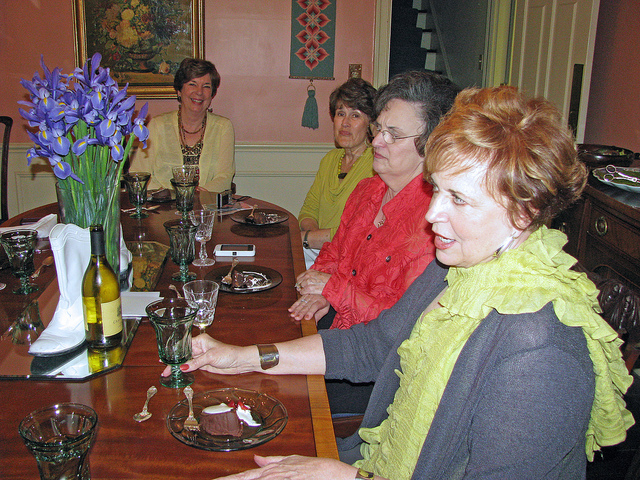

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## 6. Mise en place du CNN

### Prétraitement des images avec InceptionV3
Nous allons utiliser le modèle InceptionV3 pour classifier chaque images. Ce modèle a été pré-entrainé sur Imagenet.
Les features seront extraite de la dernière couche de convolution.

**Introduction à Inception V3**

InceptionV3 est un modèle qui utilise une série de modules dits d'"inception" ![inception module](images/inceptionV3.png)
L'utilisation de ces modules permet une réduction de l'overfitting et réduit les coûts en calcul. 
L'idée est d'appliquer des filtres de convolution de taille différente en parallèle et des les regrouper plutôt que de les exécuter séquentiellement.
Une variante de ces modules utilisant des convolutions 1x1 pour réduire le nombre de dimensions avant l'application de filtres plus coûteux, est utilisée dans ce modèle et réduit fortement la quantité de calculs requise.

InceptionV3 utilise aussi des classifieurs auxiliaires qui améliorent la convergence dans des réseaux denses. Plus d’informations sur les différents modules de l’architecture d’InceptionV3 sont disponibles sur [cette publication]( https://arxiv.org/pdf/1512.00567v3.pdf).

### Initialisation d'InceptionV3 et chargement des poids Imagenet pré-entraînés

Comme expliqué dans la partie "2. Pré-traitement", nous devons procéder à un pré-traitement sur les images avant de pouvoir les utiliser dans le modèle.

La fonction suivante permet donc de charger une image en la redimentionnant (299x299 pixels) et en la normalisant (valeurs de pixels entre -1 et 1), format qu'utilise le modèle Inception V3 par défaut.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))# 299px/299px
    img = tf.keras.applications.inception_v3.preprocess_input(img) #normalisation
    return img, image_path



Le code suivant permet de charger le modèle pré-entrainé InceptionV3. Le dernière couche de convolution est de la forme ```8x8x2048```.

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet') #poids de imageNet
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#On créer un le nouveau modèle
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 


### Mise en cache
On traite ensuite chaque images avec le modèle. On obtient donc des vecteurs de la forme ```8x8x2048``` que l'on stoque dans un dictionnaire.

In [12]:
#Barre de progression pour la mise en cache
!pip install -q tqdm

In [13]:
from tqdm import tqdm

# Prendre les noms des images et qu'elles soient uniques
encode_train = sorted(set(img_name_vector))

# On CHANGE LA TAILLE DES BATCHS ICI ==> 16
# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [03:32<00:00,  1.70s/it]


### 7. Prétraitement du texte 

In [14]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

- Tout d'abord, nous allons tokeniser les descriptions. Cela nous donne un vocabulaire de tous les mots uniques dans les descriptions (par exemple, «surf», «football», etc.).
- Ensuite, nous allons limiter la taille du vocabulaire aux 5 000 premiers mots (pour économiser de la mémoire). On remplace tous les autres mots par le jeton "UNK" (inconnu).

In [15]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)


In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


On créé ensuite des mappages mot-à-index et index-mot.

In [17]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)


Enfin, on remplit toutes les séquences pour qu'elles aient la même longueur que la plus longue.

In [18]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [19]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


## 8. Préparation du jeu d'entrainement et du jeu de validation

On sépare le jeu de données en jeu de test et de validation avec un split 80%-20%

In [20]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(8003, 8003, 2000, 2000)

On définit d'abord les paramètres de notre datasets.  

Le <code translate="no" dir="ltr">BATCH_SIZE</code> de 64. La nombre d'éléments dans chaque batch.  
<code translate="no" dir="ltr">BUFFER_SIZE</code> de 1000. Le nombre d'éléments maximum que l'on prefetch.  
<code translate="no" dir="ltr">embedding_dim</code> de 256. Nombre standard de neurones que l'on définit pour chaque couche. (plus sur les couches de convolutions)  
<code translate="no" dir="ltr">units</code> de 512. Nombre standard de neurones que l'on définit pour chaque couche. (plus sur les couches denses et GRUs)  
<code translate="no" dir="ltr">vocab_size</code>. Taille du vocabulaire. Définit à 5000 + 1.  
<code translate="no" dir="ltr">num_steps</code>. Nombre de step pour chaque epochs durant le training.  
<code translate="no" dir="ltr">attention_features_shape</code> de 64. Utilisé pour la représentation graphique où l'on montre quelles features sont utilisées pour générer chaque mot dans les labels créés. Dans notre cas, on divise l'image en 64 zones pour montrer sur quelles zones se concentre le modèle pour détecter le mot à associer pour décrire l'image.

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [23]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=AUTOTUNE)

dataset_test = dataset_test.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### 9. Modèles de notre encodeur et de notre décodeur

Cette architecture de modèle est inspirée par le papier [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf).
On extrait d'abord les features de la couche convolutionnelle inférieure de InceptionV3 qui donne un vecteur de forme (8,8,2048). 
On l'écrase pour obtenir une forme de (64,2048).  
Ce vecteur est ensuite passé à travers l'encodeur CNN (qui consiste en une seule couche entièrement connectée, une couche dense).
Le RNN (GRU) passe sur l'image pour prédire le prochain mot.

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [27]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout=0.4)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.dp1 = tf.keras.layers.Dropout(0.4)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru1(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    x = self.dp1(x)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [28]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [83]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
acc_function = tf.keras.metrics.CategoricalAccuracy()

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoints

Afin de pouvoir interrompre et reprendre l'entrainement du modèle, on met en place un CheckpointManager et on enregistre l'encodeur, le décodeur et l'optimiseur. Les checkpoints se font toutes les 5 époques et sont enregistrés dans "./checkpoints/train" pour un maximum de 5.

In [84]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [85]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)


## Préparation pour l'entraînement

On extrait les features stockées dans les fichiers `.npy` respectifs, puis on les fait passer par l'encodeur.  
La sortie de l'encodeur, le hidden state (initialisé à 0) et l'entrée du decodeur (qui est le token de départ) sont transmis au decodeur.  
Le decodeur renvoie les prédictions et le hidden state du decodeur.  
Le hidden state du decodeur est ensuite renvoyé dans le model et les prédictions sont utilisées pour calculer la perte et l'accuracy.
On utilise le **teacher forcing** pour décider de la prochaine entrée dans le decodeur.  
Le teacher forcing est une technique par laquelle le mot cible est transmis comme prochaine entrée au decodeur.  
L'étape finale consiste à calculer les gradients et à les appliquer à l'optimiseur pour ensuite appliquer la backpropagation.  

In [86]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot = []

In [87]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    acc = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #calculate cumulated loss and accuracy
            loss += loss_function(target[:, i], predictions)
            acc += acc_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    #calculate average loss and accuracy for the batch
    total_loss = (loss / int(target.shape[1]))
    total_acc = (acc / int(target.shape[1]))
    #calculate gradient and apply gradient descent
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss, acc, total_acc

On créé une fonction similaire qui calcule la perte et l'accuracy sur le jeu de validation (on verra par la suite qu'elle n'a pas bien fonctionée).

In [88]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    acc = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        acc += acc_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    total_acc = (acc / int(target.shape[1]))

    return loss, total_loss, acc, total_acc

## 10. Entrainement du modèle

On peut enfin entrainer notre modèle

In [90]:
EPOCHS = 10
start_epoch=0

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_acc = 0
    validation_loss = 0
    validation_acc = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss, batch_acc, t_acc = train_step(img_tensor, target)
        total_loss += t_loss
        total_acc += t_acc

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Acc {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), batch_acc.numpy()/ int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    for (batch, (img_tensor, target)) in enumerate(dataset_test):
        batch_loss, t_loss, batch_acc, t_acc = test_step(img_tensor, target)
        validation_loss += t_loss
        validation_acc += t_acc
    val_loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} ACC : {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, total_acc/num_steps))
    print("val loss : ", validation_loss/num_steps_val)
    print("val acc : ", validation_acc/num_steps_val)
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.0182 Acc 0.0059
Epoch 1 Batch 100 Loss 0.9325 Acc 0.0061
Epoch 1 Loss 0.972808 ACC : 0.005956
val loss :  tf.Tensor(1.041295, shape=(), dtype=float32)
val acc :  tf.Tensor(0.006331759, shape=(), dtype=float32)
Time taken for 1 epoch 1006.310272693634 sec

Epoch 2 Batch 0 Loss 0.8559 Acc 0.0062
Epoch 2 Batch 100 Loss 0.8736 Acc 0.0067
Epoch 2 Loss 0.888651 ACC : 0.006460
val loss :  tf.Tensor(1.0236864, shape=(), dtype=float32)
val acc :  tf.Tensor(0.00711417, shape=(), dtype=float32)
Time taken for 1 epoch 1004.5978841781616 sec

Epoch 3 Batch 0 Loss 0.8720 Acc 0.0068
Epoch 3 Batch 100 Loss 0.7736 Acc 0.0065
Epoch 3 Loss 0.821328 ACC : 0.006671
val loss :  tf.Tensor(1.0035787, shape=(), dtype=float32)
val acc :  tf.Tensor(0.0067466646, shape=(), dtype=float32)
Time taken for 1 epoch 1022.6476314067841 sec

Epoch 4 Batch 0 Loss 0.7790 Acc 0.0065
Epoch 4 Batch 100 Loss 0.7532 Acc 0.0062
Epoch 4 Loss 0.768097 ACC : 0.006387
val loss :  tf.Tensor(0.98666954, shape=()

Nous n'avons malheureusement pas réussi à afficher correctement les résultats de la fonction de coût et l'accuracy du modèle sur les jeux d'entrainement et de validation. Les chiffres visibles ci-dessus ne sont pas vraiment exploitables pour l'évaluer mais nous ne disposons malheureusement pas du temps nécessaire pour corriger l'erreur et ré-entrainer le modèle.

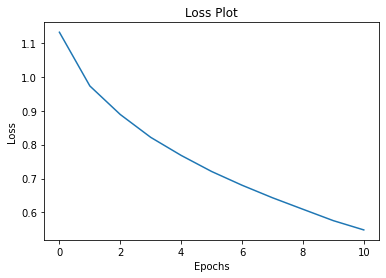

In [116]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

On remarque quand même une baisse du résultat de la fonction de coût mais nous ne sommes pas certains que les chiffres affichés correspondent réellement au coût utilisé pour l'entrainement. Nous allons donc devoir évaluer les performances du modèle à l'oeil pour la suite en affichant des images et en regardant si la description générée est cohérente.

## 11. Prédiction

La fonction `evaluate` est similaire à la boucle d'entraînement, à la différence que l'on n'utilise pas le teacher forcing ici. Les entrées du decoder à chaque pas de temps correspondent au mot prédit précédemment (ou au tag \<start> au début de la prédiction), le hidden state et la sortie de l'encoder correspondent aux features de l'image.
On arrête de prédire quand le modèle prédit le token \<fin>.
On stocke les attention_weights pour chaque pas de temps.

In [94]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [95]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


## 12. Éxecution du modèle

On va maintenant essayer notre modèle sur différentes images.

Dans un premier temps un test rapide sur une image non labelisé montrant comment le modèle a déterminé chaque mot.

Prediction Caption: a surfer riding on to the day <end>


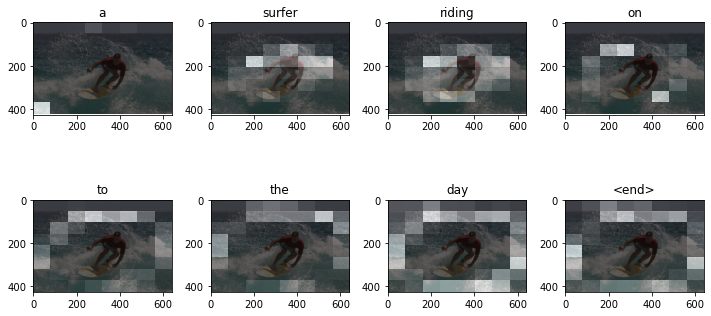

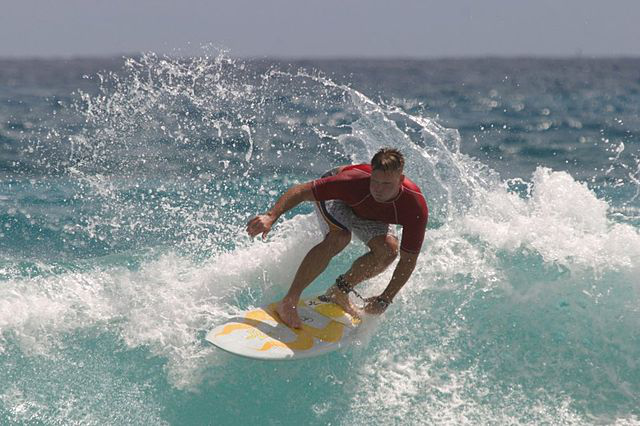

In [98]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


On peut voir que le modèle reconnait les idées principales. C'est peut être même un poête.

**Test sur plusieurs images labélisées**

On va maintenant le tester sur plusieurs image du jeu de validation. L'avantage est qu'on pourra comparer le résultat obtenu avec celui attendu

Real Caption: <start> baseball players standing on the field during a game <end>
Prediction Caption: a group of baseball players stand as a ball while in a white and a practice is performing a field with a player throwing a grass walk against a dry field <end>


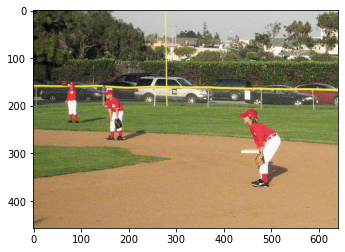

Real Caption: <start> a young blue eyed child brushing it's teeth with a tooth brush <end>
Prediction Caption: a young child standing on her <end>


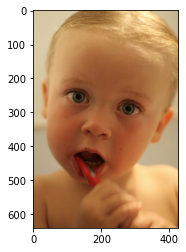

Real Caption: <start> this is a high tech science machine next to a waterbottle <end>
Prediction Caption: a modern refrigerator is covered with door on <end>


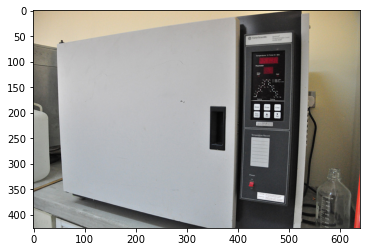

Real Caption: <start> a small red bus is driving through the desert <end>
Prediction Caption: a single motorcycle truck parked at an orange school bus <end>


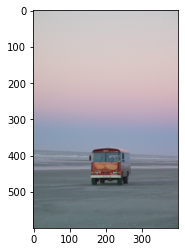

Real Caption: <start> the girl is texting on her phones keyboard <end>
Prediction Caption: two people on his laptop and a black and a woman <end>


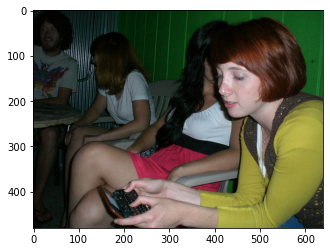

Real Caption: <start> the old man with glasses is holding orange scissors <end>
Prediction Caption: a woman that is about to the tv holding holding a piece of tennis <end>


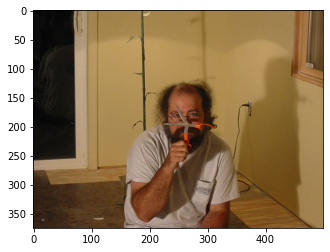

Real Caption: <start> a bathroom mirror is shown with hanging lights and a mirror vanity <end>
Prediction Caption: a white bathroom with a trendy sliding meat and all over <end>


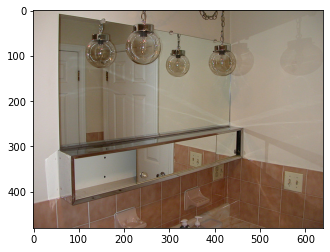

Real Caption: <start> a bus driving down a street next to tall buildings <end>
Prediction Caption: a city bus driving down a cross the road <end>


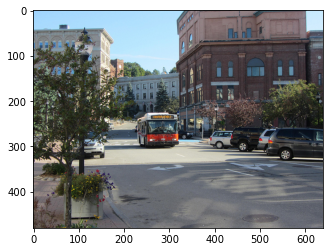

Real Caption: <start> a man on foot leading an woman riding and an elephant <end>
Prediction Caption: a couple of elephants walking through a dirt tracks in the middle of the water <end>


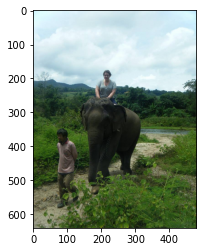

In [114]:
for i in range(9) :
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', ' '.join(result))
    plt.imshow(np.array(Image.open(image)))
    plt.show()

On remarque que le modèle reconnait encore une fois les idées générales. Il y a quelques ratés mais on remarque que les descriptions humaines ne sont pas toujours très pertinentes et c'est sur ce genre de description que notre modèle s'est entrainé.

## Conclusion

En conclusion, dans ce notebook nous avons implémenté le dernier module de la solution : le captioning d'images. 

Ce module est composé d'un encodeur et d'un décodeur. InceptionV3, un modèle de réseau de neurones convolutifs pré-entrainé fait office d'encodeur. Celui-ci prend en entrée des images redimensionnées et normalisées préalablement et fait ressortir des `features` sous forme de vecteurs.

Notre décodeur, un réseau de neurones récurrent entrainé sur le jeu de données MS-COCO, est ensuite chargé de générer une description en fonction des `features` en sortie de l’encodeur. Pour se faire il utilise des GRU qui sont une version avancée des neurones généralement utilisés dans les RNN ainsi qu'un `mécanisme d'attention de Badhanau` pour quantifier et prendre en charge l’interdépendance entre les `features` et les mots utilisés.

Nous n'avons pas réussi a implémenter une méthode objective de mesure des performances du modèle. Nous les avons donc mesuré à l'oeil et estimons qu'il fait un travail satisfaisant puisqu'il arrive à reconnaitre les grandes idées. Nous ne pouvons pas savoir si nous sommes en overfit ou en underfit mais nous supposons qu'avec les valeurs de Dropout utilisées nous pouvons encore entrainer le modèle sur quelques époques et augmenter ses performances.